# Schematic view of mechanism:

<img src="images/full_scheme.png" alt="Image" width="600" height="300">


In [1]:
from matplotlib.animation import FuncAnimation
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me
from IPython.display import HTML

In [2]:
# Variable definititon

l_ol1, l_ol2, l_or1, l_or2, l_il, l_ir = sm.symbols('l_ol1, l_ol2, l_or1, l_or2, l_il, l_ir')

a, q1, q2 = me.dynamicsymbols('a, q1, q2')

# definition of other dependent angles
q3 = q2 - sm.pi

N = me.ReferenceFrame('N')
A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')
C = me.ReferenceFrame('C')
D = me.ReferenceFrame('D')

# Reference frames orientation
A.orient_axis(N, N.z, q1) # l_ir
B.orient_axis(A, A.z, q2) # l_or1, l_or2
C.orient_axis(A, A.z, q2 - sm.pi) # l_il
D.orient_axis(N, N.z, q1) # l_ol

# Point definition - joints and centers of mass
O, P1, P2, P3, P4, P5 = sm.symbols('O, P1, P2, P3, P4, P5', cls = me.Point)
Ao, Bo, Co, Do = sm.symbols('Ao, Bo, Co, Do', cls = me.Point)

# Tuple with center of mass of bodies - from 3D model [m]
(-0.085354, 0.200053)          # l_or
(-0.041021 + 0.120, 0.192828)  # l_ol
(-0.023011, 0.055996)          # l_il
(0.075443, 0.129648)           # l_ir

# Ao
Ao_x = (0.075443*N.x + 0.129648*N.y).dot(A.x)
Ao_y = (0.075443*N.x + 0.129648*N.y).dot(A.y)

# Bo
Bo_x = (0.075443*N.x + 0.129648*N.y).dot(A.x)
Bo_y = (0.075443*N.x + 0.129648*N.y).dot(A.y)

Ao.set_pos(O, Ao_x*A.x + Ao_y*A.y)
 

# Point position definition - ref scheme in Figure 1
P1.set_pos(P2, l_or1 * B.x)
P2.set_pos(O, l_ir * A.x)
P3.set_pos(P2, - l_or2 * B.x)
P4.set_pos(P3, - l_ol2 * A.x)
P5.set_pos(P4, - l_ol1 * A.x)

In [3]:
# Kinematic loop - holonomic constraint
loop1 = l_ir * A.x + l_or1 * B.x - a * N.x

# Holonomic constraints - loop projections
fh1 = loop1.dot(N.x).simplify()
fh2 = loop1.dot(N.y).simplify()

# Holonomic constraint - P5 collinear position
fh3 = P5.pos_from(P3).dot(N.y) + P3.pos_from(P1).dot(N.y)

# Constraints system of equations
pant_repl = {l_ol2: l_ir}
fh_expr = sm.Matrix([fh1, fh2, fh3])
fh_expr = fh_expr.xreplace(pant_repl)


transmission = -P5.pos_from(O).dot(N.x) / P1.pos_from(O).dot(N.x)
pant_repl = {l_ol2: l_ir}
transmission = transmission.xreplace(pant_repl)
transmission = sm.trigsimp(transmission)


# PRBM - schematic view of mechanism:


![OpenAI Logo](images/prbm.png)


### OBJECTIVE:
The objective is to calculate the force needed to actuate the mechanism

In [5]:
# ### Definition of different types of compliant joints ### 

E = 210e9 # Young modulus dependent on material

# Rectangular joint
t_r, b_r, L_r = [2e-3,5e-2,0.1]
I_r = (1/12) * b_r * (t_r**3);
K_r = (E*I_r)/L_r

# Cartwheel joint
t_cw, b_cw, L_cw = [0,0,1]
I_cw = (1/12) * b_cw * (t_cw**3);
K_cw = 8*((E * I_cw) / L_cw)

# Cross flexure joint - just herder dim
t_cf, b_cf, L_cf = [0.5e-3,10e-3,50e-3]
I_cf = (1/12)*(b_cf/2)*(t_cf**3);
K_cf = 2*(E*I_cf)/L_cf

K_cf = K_cf*1.5


# Cross flexure joint - thick version
t_cf, b_cf, L_cf = [1e-3,7.5*1e-3,50e-3]
I_cf = (1/12)*(b_cf/2)*(t_cf**3);
K_cf = 2*(E*I_cf)/L_cf

K_cf = K_cf*1.6



In [6]:
def ang_span_calc(a_0, a_val, p, q):
    # This auxiliary function calculates the angle span of q1 and q2 corresponding 
    # to the deformation of the mechanism. Deformation of the mechanisms is between: a_0 [m] and a_0 + a_val [m]
    sol_rec = []
    for i in np.array([a_0 , a_0 + a_val]):
        
        # Mechanism set of parameters
        p_vals = np.array([0.350,     # l_ir [m] 
                           0.35,      # l_or1 [m] 
                           0.140,     # l_or2 [m] 
                           i  ])      # a [m]
        

        # Inserting numeric values in the constraints
        subs1 = {k: v for k, v in zip(p, p_vals)}
        fh = fh_expr.subs(subs1)
        
        # Creating a function to compute constraints residuals
        x0 = np.array([np.deg2rad(30), np.deg2rad(270), 0.2])
        eval_fh = sm.lambdify((q, ), fh)
        
        def sys(x):   
            # Define the equations
            fh1_val = eval_fh(x)[0, 0]
            fh2_val = eval_fh(x)[1, 0]
            fh3_val = eval_fh(x)[2, 0]

            # Return the equations as a list
            return [fh1_val, fh2_val, fh3_val]

        # Solve the system of equations
        solution = fsolve(sys, x0)
        
        # Extract the solutions for each variable: y1 and y2 are q1 and q2 span angles
        y1_solution, y2_solution = solution[0], solution[1]
        sol = np.array([y1_solution, y2_solution, solution[2]])
        sol_rec.append(sol)

    return sol_rec
    
    
def PRBM(q, x_vec, p, p_vals, k, k_vals, phis, q_expr, omega1, omega2, ul, dyn_repl, om_repl, sol_rec):
    
    # Derivative of holonomic constraints to find relation between velocities
    fhd = sm.Matrix([fh_expr[0].xreplace(dyn_repl).diff(t).xreplace(om_repl),
                     fh_expr[1].xreplace(dyn_repl).diff(t).xreplace(om_repl)])

    # Angular speeds as function of linear speed                 
    sol = sm.solve(fhd, (omega1, omega2))

    # To find the actuation force, the virtual work principle has to be used --->
    # ---> virtual displacement have to be found d_ang/d_a
    virtual_disp = sm.trigsimp(q_expr.xreplace(dyn_repl).diff(t).xreplace(om_repl))/ul#.xreplace(sol)/ul)
    eval_vdisp = sm.lambdify((x_vec, p), virtual_disp)

    # Symbolic force expression1
    Fl = k1 * phi1 * virtual_disp[0]+ \
         k2 * phi3 * virtual_disp[2]+ \
         k3 * phi4 * virtual_disp[3]+ \
         k4 * phi1 * virtual_disp[0]+ \
         k5 * phi3 * virtual_disp[2]+ \
         k6 * phi3 * virtual_disp[2]+ \
         k7 * phi4 * virtual_disp[3]

    Fl = sm.trigsimp(Fl.xreplace(sol))
    
    # Angles evaluation 
    eval_q = sm.lambdify((q[:2],), q_expr)
    phi_vals = np.rad2deg(eval_q(sol_rec[-1][:2]) - eval_q(sol_rec[0][:2]))
    
    x_vals = sol_rec[-1][:2]
    

    eval_Fl = sm.lambdify((x_vec, phis, k, p), Fl)
    
    return eval_Fl(x_vals, np.deg2rad(phi_vals), k_vals, p_vals)
    

    
    

In [7]:
# Definition of symbols needed for the PRBM 
x1, x2, xl = me.dynamicsymbols('x1, x2, xl')
x_vec = [x1, x2]

# Mech parameters
p = [l_ir, l_or1, l_or2, a]
q = [q1, q2, l_ol1] 

# Angular velocities and linear velocity of blade
omega1, omega2, ul = me.dynamicsymbols('omega_1, omega_2, ul')
t = me.dynamicsymbols._t

# Joints' spring values
k1, k2, k3, k4, k5, k6, k7 = sm.symbols('k1, k2, k3, k4, k5, k6, k7')
k = [k1, k2, k3, k4, k5, k6, k7]
k_vals = [K_cf, K_cf, K_cf, K_cf, K_cf, K_cf, K_cf]

# All span angles variables
phi1, phi2, phi3, phi4, phi5 = sm.symbols('phi1, phi2, phi3, phi4, phi5')
phis = [phi1, phi2, phi3, phi4, phi5]

 # For the PRBM the angles at all the joint between starting and deformed position are needed
q3 = q2 - np.pi
q4 = np.pi - q1 - q3
q5 = np.pi - q3 
q_expr = sm.Matrix([q1, q2, q3, q4, q5])

# Dictionary to subbstitute new dynamic variable to perform time derivatives
dyn_repl = {q1:x1, q2:x2, a:xl}
om_repl = {x1.diff(t):omega1, x2.diff(t):omega2, xl.diff(t):ul}


# The goal of this cell is to plot the force needed for the actuation in the decided range of motion

force_rec = []

for j in np.arange(0, 0.1, 0.01):

    sol_rec = []

    # Values substitution: l_ir = 0.2, l_or1 = 0.3 [m]
    for i in np.array([0.3 , 0.3 + j]):
        p_vals = [0.300, 0.300, 0.120, i]
        p = [l_ir, l_or1, l_or2, a]

        subs1 = {k: v for k, v in zip(p, p_vals)}
        fh = fh_expr.subs(subs1)

        # Lambdify
        q = [q1, q2, l_ol1] 
        x0 = np.array([np.deg2rad(30), np.deg2rad(270), 0.2])
        eval_fh = sm.lambdify((q, ), fh)

        def sys(x):   
            # Define the equations
            fh1_val = eval_fh(x)[0, 0]
            fh2_val = eval_fh(x)[1, 0]
            fh3_val = eval_fh(x)[2, 0]

            # Return the equations as a list
            return [fh1_val, fh2_val, fh3_val]

        # Solve the system of equations
        solution = fsolve(sys, x0)

        # Extract the solutions for each variable
        y1_solution, y2_solution = solution[0], solution[1]
        sol = np.array([y1_solution, y2_solution, solution[2]])

        sol_rec.append(sol)

    
    # ### PRBM ###

    # Definition of symbols to derivate expressions
    x1, x2, xl = me.dynamicsymbols('x1, x2, xl')
    x_vec = [x1, x2]

    omega1, omega2, ul = me.dynamicsymbols('omega_1, omega_2, ul')
    t = me.dynamicsymbols._t

    k1, k2, k3, k4, k5, k6, k7 = sm.symbols('k1, k2, k3, k4, k5, k6, k7')
    k = [k1, k2, k3, k4, k5, k6, k7]

    phi1, phi2, phi3, phi4, phi5 = sm.symbols('phi1, phi2, phi3, phi4, phi5')
    phis = [phi1, phi2, phi3, phi4, phi5]

    # For the PRBM the angles at all the joint between starting and deformed position are needed
    q3 = q2 - np.pi
    q4 = np.pi - q1 - q3
    q5 = np.pi - q3 

    q_expr = sm.Matrix([q1, q2, q3, q4, q5])
    sm.init_printing()

    # New dynamic variable to perform time derivatives
    dyn_repl = {q1:x1, q2:x2, a:xl}
    om_repl = {x1.diff(t):omega1, x2.diff(t):omega2, xl.diff(t):ul}

    fhd = sm.Matrix([fh_expr[0].xreplace(dyn_repl).diff(t).xreplace(om_repl),
                     fh_expr[1].xreplace(dyn_repl).diff(t).xreplace(om_repl)])

    # Angular speeds as function of linear speed                 
    sol = sm.solve(fhd, (omega1, omega2))

    # To find the ectuation force, the virtual work principle has to be used --->
    # ---> virtual displacement have to be found d_ang/d_a
    virtual_disp = sm.trigsimp(q_expr.xreplace(dyn_repl).diff(t).xreplace(om_repl))/ul#.xreplace(sol)/ul)
    eval_vdisp = sm.lambdify((x_vec, p), virtual_disp)

    # Symbolic force expression1
    Fl = k1 * phi1 * virtual_disp[0]+ \
        k2 * phi3 * virtual_disp[2]+ \
        k3 * phi4 * virtual_disp[3]+ \
        k4 * phi1 * virtual_disp[0]+ \
        k5 * phi3 * virtual_disp[2]+ \
        k6 * phi3 * virtual_disp[2]+ \
        k7 * phi4 * virtual_disp[3]

    Fl = sm.trigsimp(Fl.xreplace(sol))


    # Angles evaluation 
    eval_q = sm.lambdify((q[:2],), q_expr)
    phi_vals = np.rad2deg(eval_q(sol_rec[-1][:2]) - eval_q(sol_rec[0][:2]))
    x_vals = sol_rec[-1][:2]
    k_vals = [K_cf, K_cf, K_cf, K_cf, K_cf, K_cf, K_cf]

    eval_Fl = sm.lambdify((x_vec, phis, k, p), Fl)
    force_rec.append(eval_Fl(x_vals, np.deg2rad(phi_vals), k_vals, p_vals))
    sol_rec = []


# Negative displacement
force_rec_neg = []

for j in np.arange(-0.1, 0, 0.01):

    sol_rec = []

    # Values substitution: l_ir = 0.2, l_or1 = 0.3 [m]
    for i in np.array([0.3, 0.3 + j]):
        p_vals = [0.300, 0.300, 0.120, i]
        p = [l_ir, l_or1, l_or2, a]

        subs1 = {k: v for k, v in zip(p, p_vals)}
        fh = fh_expr.subs(subs1)

        # Lambdify
        q = [q1, q2, l_ol1] 
        x0 = np.array([np.deg2rad(30), np.deg2rad(270), 0.2])
        eval_fh = sm.lambdify((q, ), fh)

        def sys(x):   
            # Define the equations
            fh1_val = eval_fh(x)[0, 0]
            fh2_val = eval_fh(x)[1, 0]
            fh3_val = eval_fh(x)[2, 0]

            # Return the equations as a list
            return [fh1_val, fh2_val, fh3_val]

        # Solve the system of equations
        solution = fsolve(sys, x0)

        # Extract the solutions for each variable
        y1_solution, y2_solution = solution[0], solution[1]
        sol = np.array([y1_solution, y2_solution, solution[2]])

        sol_rec.append(sol)

    
    # ### PRBM ###

    # Definition of symbols to derivate expressions
    x1, x2, xl = me.dynamicsymbols('x1, x2, xl')
    x_vec = [x1, x2]

    omega1, omega2, ul = me.dynamicsymbols('omega_1, omega_2, ul')
    t = me.dynamicsymbols._t

    k1, k2, k3, k4, k5, k6, k7 = sm.symbols('k1, k2, k3, k4, k5, k6, k7')
    k = [k1, k2, k3, k4, k5, k6, k7]

    phi1, phi2, phi3, phi4, phi5 = sm.symbols('phi1, phi2, phi3, phi4, phi5')
    phis = [phi1, phi2, phi3, phi4, phi5]

    # For the PRBM the angles at all the joint between starting and deformed position are needed
    q3 = q2 - np.pi
    q4 = np.pi - q1 - q3
    q5 = np.pi - q3 

    q_expr = sm.Matrix([q1, q2, q3, q4, q5])
    sm.init_printing()

    # New dynamic variable to perform time derivatives
    dyn_repl = {q1:x1, q2:x2, a:xl}
    om_repl = {x1.diff(t):omega1, x2.diff(t):omega2, xl.diff(t):ul}

    fhd = sm.Matrix([fh_expr[0].xreplace(dyn_repl).diff(t).xreplace(om_repl),
                     fh_expr[1].xreplace(dyn_repl).diff(t).xreplace(om_repl)])

    # Angular speeds as function of linear speed                 
    sol = sm.solve(fhd, (omega1, omega2))

    # To find the ectuation force, the virtual work principle has to be used --->
    # ---> virtual displacement have to be found d_ang/d_a
    virtual_disp = sm.trigsimp(q_expr.xreplace(dyn_repl).diff(t).xreplace(om_repl))/ul#.xreplace(sol)/ul)
    eval_vdisp = sm.lambdify((x_vec, p), virtual_disp)

    # Symbolic force expression1
    Fl = k1 * phi1 * virtual_disp[0]+ \
        k2 * phi3 * virtual_disp[2]+ \
        k3 * phi4 * virtual_disp[3]+ \
        k4 * phi1 * virtual_disp[0]+ \
        k5 * phi3 * virtual_disp[2]+ \
        k6 * phi3 * virtual_disp[2]+ \
        k7 * phi4 * virtual_disp[3]

    Fl = sm.trigsimp(Fl.xreplace(sol))


    # Angles evaluation 
    eval_q = sm.lambdify((q[:2],), q_expr)
    phi_vals = np.rad2deg(eval_q(sol_rec[-1][:2]) - eval_q(sol_rec[0][:2]))
    x_vals = sol_rec[-1][:2]
    k_vals = [K_cf, K_cf, K_cf, K_cf, K_cf, K_cf, K_cf]

    eval_Fl = sm.lambdify((x_vec, phis, k, p), Fl)
    force_rec_neg.append(eval_Fl(x_vals, np.deg2rad(phi_vals), k_vals, p_vals))
    sol_rec = []








In [8]:
force = force_rec_neg
force = np.abs(force).T
force = np.array([force,np.array(force_rec).T ]).flatten()
#np.hstack((force[0],force_rec[0].T))

<function matplotlib.pyplot.show(close=None, block=None)>

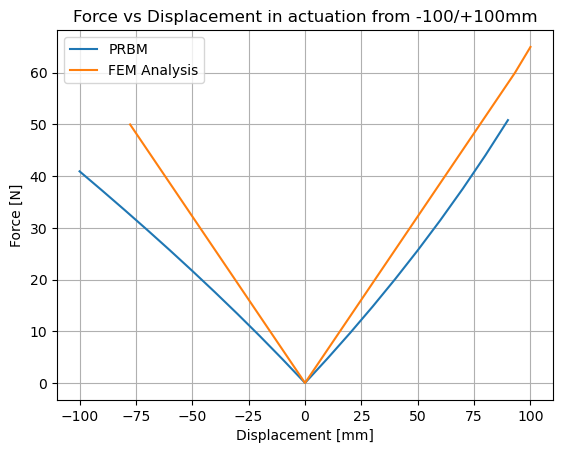

In [29]:
force_rec_neg.append(force_rec)

fig, ax = plt.subplots()
line1, = ax.plot(np.arange(-100, 100, 10), 2*force)
line1.set_label('PRBM')


F = np.array([50, 40, 30, 20, 10, 0, 10, 20, 30, 40, 50, 60, 65])
disp = np.array([-0.07759376971466657, -0.062075015771733265, -0.04655626182879975, -0.031037507885866632, -0.015518753942933316,0, 0.015518753777299452, 0.031037507554598904, 0.04655626133189832, 0.06207501510919781, \
0.07759376888649745, 0.0931125226637966, 0.1])



line2, =ax.plot(disp*1000, F)
line2.set_label('FEM Analysis')

plt.title('Force vs Displacement in actuation from -100/+100mm')
plt.xlabel('Displacement [mm]')
plt.ylabel('Force [N]')

plt.legend()

# Set equal scale
#ax.set_xscale('log')
#ax.set_yscale('log')

plt.grid()
plt.show

![OpenAI Logo](images/joints.png)

In [20]:
# Mech parameters
p = [l_ir, l_or1, l_or2, a]
q = [q1, q2, l_ol1] 

ang_span_calc(0.3, 0.01, p, q)

[array([1.12788528, 4.02741474, 0.14      ]),
 array([1.11201348, 4.05915834, 0.14      ])]